In [1]:
#ignore if not windows
import winsound

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [3]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
gray_sample = pd.read_csv('samples/2015_gray_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [4]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample    = gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample.failure = 1
nominal_sample = nominal_sample.sample(frac=(failure_sample.shape[0]+gray_sample.shape[0])/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample, gray_sample])
data_curr = data_curr.sample(frac=1)

In [5]:
#normalized
#feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
#           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
#           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [6]:
#raw
feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [7]:
scale = 'sk'
train_size = .66

if scale=='sk':
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
elif scale=='sk_manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)

    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        
        scaler = StandardScaler()
        data_sub = scaler.fit_transform(data_sub[feature_columns])
        test_sub = scaler.transform(test_sub[feature_columns])
        
        train_norm = pd.concat([train_norm,pd.DataFrame(data_sub)])
        test_norm = pd.concat([test_norm,pd.DataFrame(test_sub)])
        
        
    x_train = train_norm.sample(frac=1)#[feature_columns]
    x_val = test_norm.sample(frac=1)#[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
elif scale=='manu_global':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)
    
    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        max_ = pd.read_csv('scaling/%s_max.csv' % man.lower())
        max_.index = max_['date']
        del max_['date']
        max_.columns = ['value']
        min_ = pd.read_csv('scaling/%s_min.csv' % man.lower())
        min_.index = min_['date']
        del min_['date']
        min_.columns = ['value']
        for col in feature_columns:
            range_ = float(max_.value[col]) - float(min_.value[col])
            if range_==0:
                range_ = 1
            data_sub[col] = (data_sub[col] - float(min_.value[col]))/range_
            test_sub[col] = (test_sub[col] - float(min_.value[col]))/range_
        train_norm = pd.concat([train_norm,data_sub])
        test_norm = pd.concat([test_norm,test_sub])
        
    x_train = train_norm.sample(frac=1)[feature_columns]
    x_val = test_norm.sample(frac=1)[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
    
else:
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# *** MODELS ***
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)

In [9]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb]
models = [lr1, svm_linear, rfc, boost1, gnb]

In [10]:
f_rate = 1                 #2856/17509251 are positive  in 2015
n_rate = 17506395/2856     #17506395/17509251 are negative in 2015
print(f_rate,n_rate)
val_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},y_val)

1 6129.69012605042


In [11]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v2 = helper.weighted_evaluation_metrics(pred_val, y_val, val_sample_weights)
    eval_v = helper.evaluation_metrics(pred_val, y_val)
    eval_t = helper.evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    model_results[model]['val2'] = eval_v2
    
# *** RUN MODELS ***

In [12]:
winsound.MessageBeep()

In [13]:
models_plot = [lr1, svm_linear, rfc, boost1, gnb]
#models_plot = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, svm_rbf, svm_sig, rfc, rfc100, boost1, boost2, gnb]

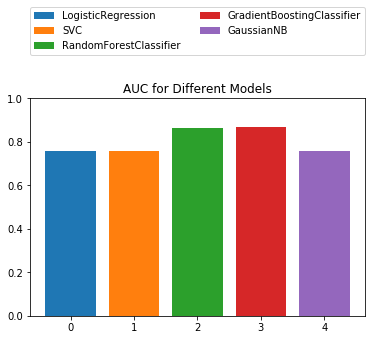

In [14]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

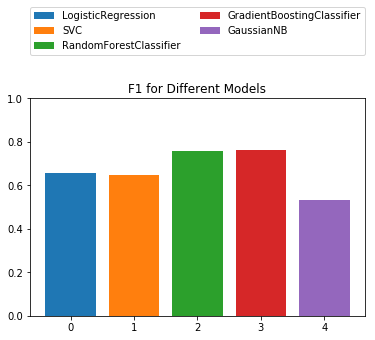

In [15]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

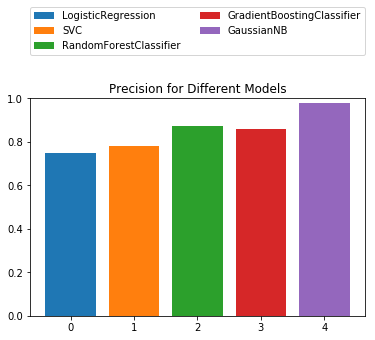

In [16]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

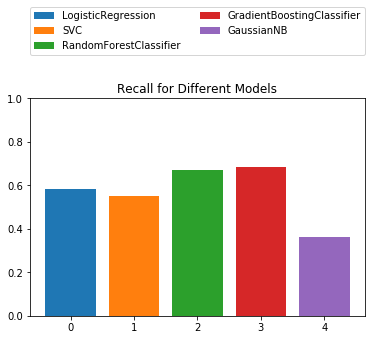

In [17]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

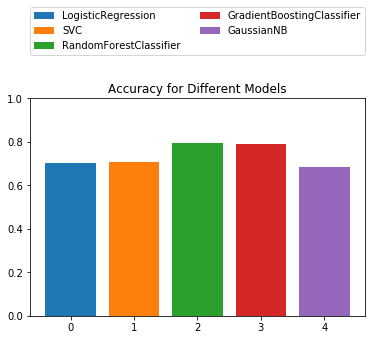

In [18]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

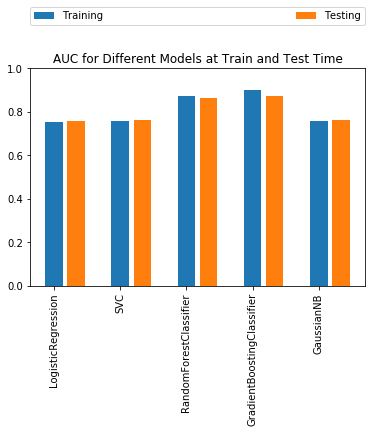

In [19]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

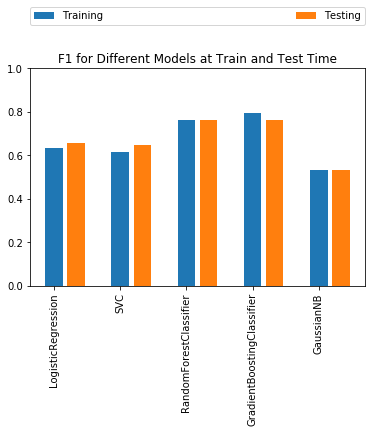

In [20]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

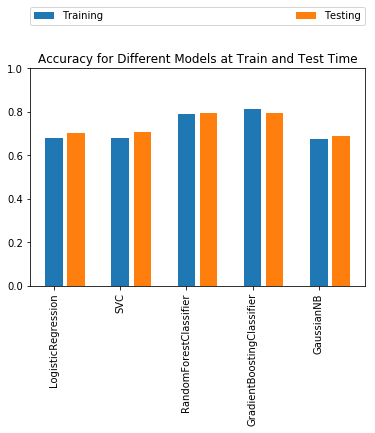

In [21]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

In [22]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']

In [23]:
metrics_


,Training Accuracy,Test Accuracy,Training Auc,Test Auc,Training F1,Test F1
Logistic Regression,0.677662,0.702238,0.754109,0.755856,0.634650,0.656663
Random Forest,0.788415,0.792816,0.872555,0.864568,0.762992,0.759371
Gradient Boosting,0.813087,0.792296,0.900008,0.869872,0.792621,0.762075


In [24]:
# load future
f_nominal_sample = pd.read_csv('samples/2018_nominal_samples_n1.csv')
f_gray_sample = pd.read_csv('samples/2018_gray_samples_n1.csv')
f_failure_sample = pd.read_csv('samples/2018_failure_samples_n1.csv')

#clean future
f_nominal_sample = f_nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_failure_sample = f_failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample    = f_gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample.failure = 1
f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0]+f_gray_sample.shape[0])/f_nominal_sample.shape[0])

#create test set
data_curr = pd.concat([f_nominal_sample, f_gray_sample, f_failure_sample])
data_curr = data_curr.sample(frac=1)
f_y_test = data_curr['failure']

if scale=='sk':
    f_x_test = data_curr[feature_columns]
    f_x_test = scaler.transform(f_x_test)
elif scale=='manu_global':
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        test_sub = data_curr[[i[:2].lower()==man.lower() for i in data_curr.model]]
        max_ = pd.read_csv('scaling/%s_max.csv' % man.lower())
        max_.index = max_['date']
        del max_['date']
        max_.columns = ['value']
        min_ = pd.read_csv('scaling/%s_min.csv' % man.lower())
        min_.index = min_['date']
        del min_['date']
        min_.columns = ['value']
        for col in feature_columns:
            range_ = float(max_.value[col]) - float(min_.value[col])
            if range_==0:
                range_ = 1
            test_sub[col] = (test_sub[col] - float(min_.value[col]))/range_
        test_norm = pd.concat([test_norm,test_sub])
        
    f_x_test = test_norm.sample(frac=1)[feature_columns]

    f_x_test = f_x_test.values




In [25]:
f_rate = 1             #1974/27342897
n_rate = 27340923/1974 #27340923/27342897
print(f_rate,n_rate)
f_sample_weights = compute_sample_weight({1:f_rate,0:n_rate},f_y_test)

1 13850.518237082068


In [26]:
for model in models:
    pred_test = model.predict_proba(f_x_test)[:,1]
    eval_f = helper.evaluation_metrics(pred_test, f_y_test)
    eval_f2 = helper.weighted_evaluation_metrics(pred_test, f_y_test, f_sample_weights)
    model_results[model]['future'] = eval_f
    model_results[model]['future2'] = eval_f2

In [56]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('SVM Linear',svm_linear),('Random Forest',rfc),('Gradient Boosting',boost1),('NB',gnb)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['val2']['recall'], model_results[model]['future2']['recall'],
               model_results[model]['val2']['specificity'], model_results[model]['future2']['specificity'],
               model_results[model]['val2']['roc_auc'], model_results[model]['future2']['roc_auc'],
              model_results[model]['val2']['precision'], model_results[model]['future2']['precision'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Weighted Test Sensitivity','Weighted Future Sensitivity','Weighted Test Specificity','Weighted Future Specificity','Weighted Test Auc','Weighted Future Auc','Weighted Test Precision','Weighted Future Precision']

In [57]:
metrics_

,Weighted Test Sensitivity,Weighted Future Sensitivity,Weighted Test Specificity,Weighted Future Specificity,Weighted Test Auc,Weighted Future Auc,Weighted Test Precision,Weighted Future Precision
Logistic Regression,0.585027,0.512422,0.813387,0.839027,0.755856,0.731043,0.000485,0.000230
SVM Linear,0.550802,0.452899,0.854970,0.889234,0.760073,0.731013,0.000587,0.000295
Random Forest,0.671658,0.536232,0.907708,0.965321,0.864568,0.780296,0.001125,0.001115
Gradient Boosting,0.683422,0.560559,0.895538,0.905280,0.869872,0.785606,0.001011,0.000427
NB,0.363636,0.400104,0.992901,0.992754,0.760157,0.738453,0.007862,0.003971


In [58]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('SVM Linear',svm_linear),('Random Forest',rfc),('Gradient Boosting',boost1),('NB',gnb)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['roc_auc'],model_results[model]['val2']['roc_auc'], model_results[model]['future2']['roc_auc'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training AUC','Test Auc','Future Auc']

In [59]:
metrics_

,Training AUC,Test Auc,Future Auc
Logistic Regression,0.754109,0.755856,0.731043
SVM Linear,0.758255,0.760073,0.731013
Random Forest,0.872555,0.864568,0.780296
Gradient Boosting,0.900008,0.869872,0.785606
NB,0.755138,0.760157,0.738453


In [29]:
winsound.MessageBeep()

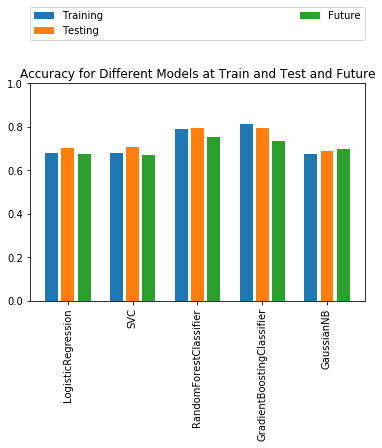

In [30]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
    data_f.append(model_results[model]['future']['accuracy'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

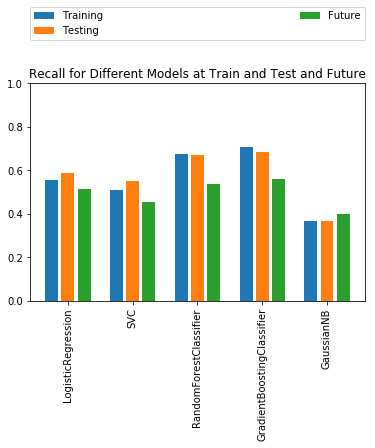

In [31]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['recall'])
    data_v.append(model_results[model]['val']['recall'])
    data_f.append(model_results[model]['future']['recall'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Recall for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [32]:
model_results[models[0]]['val']['confusion'],model_results[models[0]]['future']['confusion']

(array([[802, 184],
        [388, 547]], dtype=int64), array([[1621,  311],
        [ 942,  990]], dtype=int64))

In [33]:
model_results[models[1]]['val']['confusion'],model_results[models[1]]['future']['confusion']

(array([[843, 143],
        [420, 515]], dtype=int64), array([[1718,  214],
        [1057,  875]], dtype=int64))

In [34]:
model_results[models[2]]['val']['confusion'],model_results[models[2]]['future']['confusion']

(array([[895,  91],
        [307, 628]], dtype=int64), array([[1865,   67],
        [ 896, 1036]], dtype=int64))

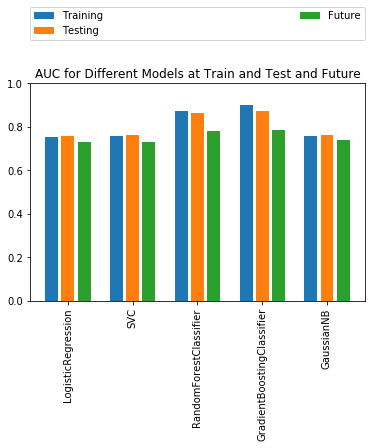

In [35]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

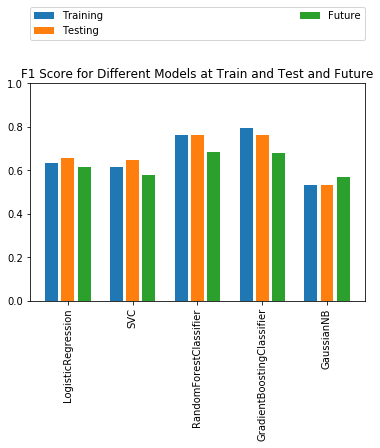

In [36]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
    data_f.append(model_results[model]['future']['f1'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 Score for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

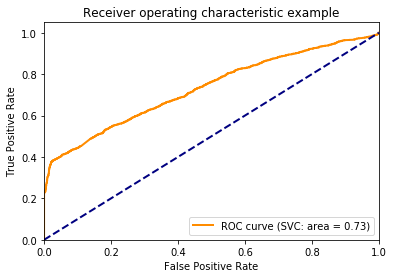

In [37]:
tpr = model_results[models[1]]['future']['tpr']
fpr = model_results[models[1]]['future']['fpr']
auc = model_results[models[1]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(models[1]).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

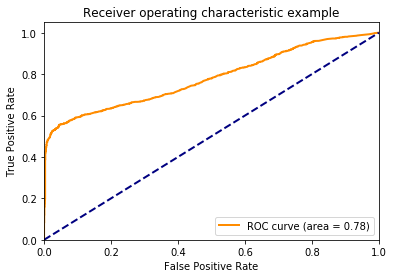

In [38]:
tpr = model_results[models[2]]['future']['tpr']
fpr = model_results[models[2]]['future']['fpr']
auc = model_results[models[2]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

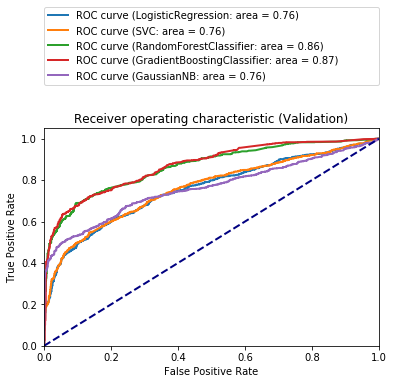

In [52]:
plt.figure()
lw = 2
for mod in models:
    tpr = model_results[mod]['val']['tpr']
    fpr = model_results[mod]['val']['fpr']
    auc = model_results[mod]['val']['roc_auc']
    plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(mod).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Validation)')
plt.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score, f1_score


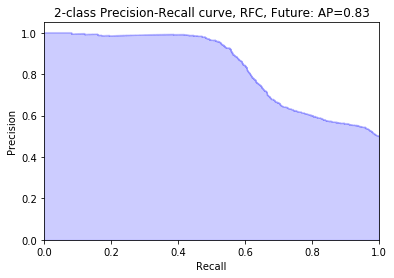

In [53]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve, RFC, Future: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [42]:
from sklearn.metrics import f1_score

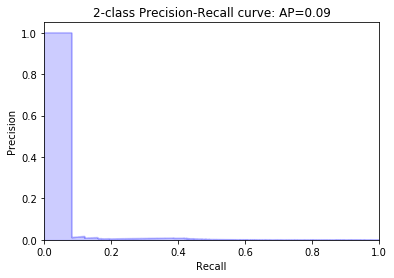

In [43]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
average_precision = average_precision_score(f_y_test, f_y_score, sample_weight=f_sample_weights)
precision, recall, _ = precision_recall_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Weighted Precision-Recall curve, RFC, Future: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [44]:
from sklearn.metrics import roc_curve,auc,confusion_matrix

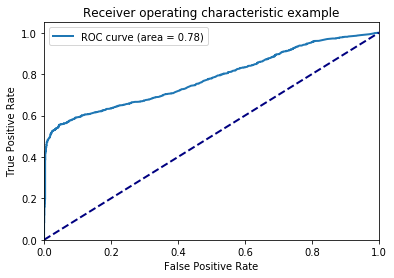

In [45]:
f_y_score = rfc.predict_proba(f_x_test)[:,-1]
fpr, tpr, thresholds = roc_curve(f_y_test, f_y_score, sample_weight=f_sample_weights)
plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import precision_score,recall_score,roc_curve

In [47]:
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        fpr,tpr,_ = roc_curve(f_y_test,f_y_score)
        print("AUC",auc(fpr,tpr))
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        ap = average_precision_score(f_y_test,f_y_score)
        print("AP",ap)
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        f1 = f1_score(f_y_test,1*(f_y_score>.5))
        print("F1",f1)

AUC 0.7310426927544806
AUC 0.73101282100742
AUC 0.7802959794503812
AUC 0.7856057829559046
AUC 0.7384531632438734
AP 0.7802025521139011
AP 0.7821477656288472
AP 0.834651280291485
AP 0.834844310429786
AP 0.797312878251621
F1 0.6124342715743891
F1 0.5792783846408475
F1 0.6827018121911038
F1 0.677298311444653
F1 0.5685913938948143


In [48]:
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        fpr,tpr,_ = roc_curve(f_y_test,f_y_score,sample_weight=f_sample_weights)
        print("AUC",auc(fpr,tpr))
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        ap = average_precision_score(f_y_test,f_y_score,sample_weight=f_sample_weights)
        print("AP",ap)
for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        f1 = f1_score(f_y_test,1*(f_y_score>.5),sample_weight=f_sample_weights)
        print("F1",f1)

AUC 0.7310426927544711
AUC 0.7310128210074107
AUC 0.7802959794503734
AUC 0.785605782955897
AUC 0.738453163243865
AP 0.22216012381036376
AP 0.2267223653604845
AP 0.08546910565139852
AP 0.08815108633867554
AP 0.00359796245732413
F1 0.00045935058522300425
F1 0.000589857570424663
F1 0.0022256769342762295
F1 0.0008535422943963757
F1 0.007863192441846878


In [49]:
for thres in (np.arange(0,1,.1)):
    print(thres)
    for model in models_plot:
        f_y_score = model.predict_proba(f_x_test)[:,-1]
        #print(confusion_matrix(f_y_test,1*(f_y_score>thresh),sample_weight=f_sample_weights))
        print("Precision",precision_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("Recall",recall_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))
        print("F1",f1_score(f_y_test,1*(f_y_score>thres),sample_weight=f_sample_weights))

0.0
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.211948356976975e-05
Recall 0.9984472049689441
F1 0.00014422854927424034
0.1
Precision 7.215688720164328e-05
Recall 0.9994824016563147
F1 0.00014430335652999263
Precision 7.215688720164328e-05
Recall 0.9994824016563147
F1 0.00014430335652999263
Precision 7.219425213063818e-05
Recall 1.0
F1 0.00014437808099369495
Precision 7.208209928514249e-05
Recall 0.9979296066252588
F1 0.00014415378610486322
Precision 0.003745106901136585
Recall 0.40424430641821946
F1 0.007421457970660637
0.2
Precision 7.208209928514249e-05
Recall 0.9979296066252588
F1 0.00014415378610486322
Precision 7.215688720164328e-05
Recall 0.9994824016563147
F1 0.00014430335652999263
Precision 7.990000230856702e-05
Recall 0.9767080745341615

In [50]:
thresh = .5
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    print(confusion_matrix(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))
    print(precision_score(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))
    print(recall_score(y_val,1*(y_score>thresh),sample_weight=val_sample_weights))

[[4.91601148e+06 1.12786298e+06]
 [3.88000000e+02 5.47000000e+02]]
0.00048475288959430374
0.5850267379679145
[[5.16732878e+06 8.76545688e+05]
 [4.20000000e+02 5.15000000e+02]]
0.0005871885572246717
0.5508021390374331
[[5.48607266e+06 5.57801801e+05]
 [3.07000000e+02 6.28000000e+02]]
0.0011245818155589168
0.6716577540106952
[[5.41251638e+06 6.31358083e+05]
 [2.96000000e+02 6.39000000e+02]]
0.001011080616042959
0.6834224598930482
[[6.00096663e+06 4.29078309e+04]
 [5.95000000e+02 3.40000000e+02]]
0.007861665962505772
0.36363636363636365


In [51]:
thresh = .5
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    tn, fp, fn, tp = (confusion_matrix(y_val,1*(y_score>thresh)).ravel())
    print(str(model).split('(')[0])
    print([tn, fp, fn, tp])
    print("Specificity",recall_score(y_val,1*(y_score>thresh),pos_label=0)) #specificity
    print("Sensitivity",recall_score(y_val,1*(y_score>thresh),pos_label=1)) #sensitivity
    print(tn/(tn+fp))
    print(tp/(fn+tp))
for model in models_plot:
    y_score = model.predict_proba(x_val)[:,-1]
    tn, fp, fn, tp = (confusion_matrix(y_val,1*(y_score>thresh),sample_weight=val_sample_weights).ravel())
    print(str(model).split('(')[0])
    print([tn, fp, fn, tp])
    print("Specificity",recall_score(y_val,1*(y_score>thresh),pos_label=0,sample_weight=val_sample_weights)) #specificity
    print("Sensitivity",recall_score(y_val,1*(y_score>thresh),pos_label=1,sample_weight=val_sample_weights)) #sensitivity
    print(tn/(tn+fp))
    print(tp/(fn+tp))

LogisticRegression
[802, 184, 388, 547]
Specificity 0.8133874239350912
Sensitivity 0.5850267379679145
0.8133874239350912
0.5850267379679145
SVC
[843, 143, 420, 515]
Specificity 0.8549695740365112
Sensitivity 0.5508021390374331
0.8549695740365112
0.5508021390374331
RandomForestClassifier
[895, 91, 307, 628]
Specificity 0.907707910750507
Sensitivity 0.6716577540106952
0.907707910750507
0.6716577540106952
GradientBoostingClassifier
[883, 103, 296, 639]
Specificity 0.8955375253549696
Sensitivity 0.6834224598930482
0.8955375253549696
0.6834224598930482
GaussianNB
[979, 7, 595, 340]
Specificity 0.9929006085192698
Sensitivity 0.36363636363636365
0.9929006085192698
0.36363636363636365
LogisticRegression
[4916011.481092376, 1127862.9831932755, 388.0, 547.0]
Specificity 0.8133874239350932
Sensitivity 0.5850267379679145
0.8133874239350897
0.5850267379679145
SVC
[5167328.7762604365, 876545.6880252084, 420.0, 515.0]
Specificity 0.8549695740365127
Sensitivity 0.5508021390374331
0.8549695740365097
0.

1428 failures / 17509251 total samples
Actually {} failures 2856
Out of {} 17509251
So {} non failures 17506395